## RDKit workshop: small-molecule profiling and triage

This notebook is a hands-on introduction to basic cheminformatics with RDKit.

We will:
1. Represent molecules using SMILES and convert them into RDKit `Mol` objects.  
2. Calculate simple molecular properties (molecular weight, logP, TPSA, H-bond donors/acceptors, etc.).  
3. Load real antiviral screening data from the COVID Moonshot project (SARS-CoV-2 Mpro inhibitors), clean it, and work with it as a `pandas` dataframe.  
4. Visualise molecules directly inside the notebook.  
5. Explore structure–activity relationships:
   - distributions of potency and properties  
   - how potency relates to size, lipophilicity, etc.  
   - series-level differences  
6. Apply medicinal chemistry filters:
   - Lipinski “Rule of Five”  
   - PAINS / structural alert flags  
7. Compare the dataset to a reported preclinical lead molecule and find similar analogues.

The aim is not to cover all of RDKit, but to build a practical workflow you could use in a real hit triage setting:
load data → clean data → calculate properties → visualise chemistry → ask SAR questions → prioritise compounds.


***
## Task: What is a SMILES string and how do we load it in RDKit?

**SMILES** (Simplified Molecular Input Line Entry System) is a way to write a molecule as plain text:
- Atoms are letters: `C` = carbon, `O` = oxygen, `N` = nitrogen.
- Bonds are usually implied. For example:
  - `"CCO"` means C–C–O (ethanol backbone)
  - `"c1ccccc1"` means an aromatic 6-membered ring (benzene)
  - `"CC(=O)O"` means acetic acid, with a double bond `=O`

In RDKit, you can turn a SMILES string into a molecule object using `Chem.MolFromSmiles(smiles)`. That gives you a `Mol`, which RDKit can then analyze, draw, etc.


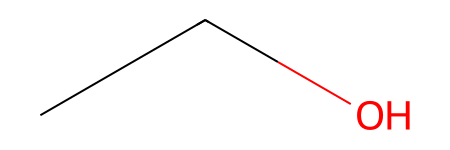

In [1]:
from rdkit import Chem

# Example SMILES strings
smiles_ethanol = "CCO"         # ethanol
smiles_benzene = "c1ccccc1"    # benzene
smiles_acetic = "CC(=O)O"      # acetic acid

# Read one SMILES into an RDKit Mol
mol = Chem.MolFromSmiles(smiles_ethanol)

mol  # this is now an RDKit Mol object


## Section: Basic molecular descriptors

This section:
1. Creates an RDKit molecule from a SMILES string.
2. Calculates common small-molecule descriptors:
   - Molecular weight  
   - logP  
   - Topological polar surface area (TPSA)  
   - Number of H-bond donors  
   - Number of H-bond acceptors  
   - Number of rotatable bonds  
   - Ring count  
3. Prints the descriptor values.


In [2]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Crippen, Lipinski

# Create an RDKit Mol object from a SMILES string
smiles = "CCO"  # ethanol
mol = Chem.MolFromSmiles(smiles)

# Calculate basic descriptors
mw  = rdMolDescriptors.CalcExactMolWt(mol)       # molecular weight
logp = Crippen.MolLogP(mol)                      # logP
tpsa = rdMolDescriptors.CalcTPSA(mol)            # topological polar surface area
hbd = Lipinski.NumHDonors(mol)                   # H-bond donors
hba = Lipinski.NumHAcceptors(mol)                # H-bond acceptors
rot_bonds = Lipinski.NumRotatableBonds(mol)      # rotatable bonds
rings = rdMolDescriptors.CalcNumRings(mol)       # ring count

# Print results
print("SMILES:", smiles)
print("Molecular weight:", mw)
print("logP:", logp)
print("TPSA:", tpsa)
print("H-bond donors:", hbd)
print("H-bond acceptors:", hba)
print("Rotatable bonds:", rot_bonds)
print("Ring count:", rings)


SMILES: CCO
Molecular weight: 46.041864812
logP: -0.0014000000000000123
TPSA: 20.23
H-bond donors: 1
H-bond acceptors: 1
Rotatable bonds: 0
Ring count: 0


## Section: Load cleaned dataset

This section:
1. Reads the pre-cleaned file `activity_data_cleaned.csv`.  
   - This file already has only valid rows (no missing `f_avg_IC50`).  
   - It only contains the columns needed for the workshop: `SMILES`, `CID`, `f_avg_IC50`, `series`.  
2. Adds an RDKit Mol object for each SMILES in a new column called `mol`.  
3. Prints how many rows were loaded and shows the first few rows.


In [3]:
import pandas as pd
from rdkit import Chem

# Read the cleaned activity data file
df = pd.read_csv("activity_data.csv")

# Convert SMILES strings (column "SMILES") to RDKit Mol objects
df["mol"] = df["SMILES"].apply(Chem.MolFromSmiles)

# Report dataset size
n_total = len(df)
print("Total rows loaded:", n_total)

# Show the first few rows
df.head()


Total rows loaded: 1926


,SMILES,CID,f_avg_IC50,series,mol
0,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,LUO-POS-e1dab717-11,0.275118,3-aminopyridine-like,<rdkit.Chem.rdchem.Mol object at 0x70531a162ea0>
1,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,LUO-POS-e1dab717-12,0.202767,3-aminopyridine-like,<rdkit.Chem.rdchem.Mol object at 0x70531a162f10>
2,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,MAT-POS-e48723dc-1,55.453947,Ugi,<rdkit.Chem.rdchem.Mol object at 0x70531a162f80>
3,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,MAT-POS-e48723dc-2,0.050000,Ugi,<rdkit.Chem.rdchem.Mol object at 0x70531a162ff0>
4,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,LUO-POS-9931618f-2,0.052757,Ugi,<rdkit.Chem.rdchem.Mol object at 0x70531a163060>


## Section: Visualise a random sample of molecules

This section:
1. Selects a random sample of 4 rows from the cleaned dataset (`df_clean`).  
2. Draws the corresponding molecules in a grid.  
3. Uses each molecule's `f_avg_IC50` value as the legend.


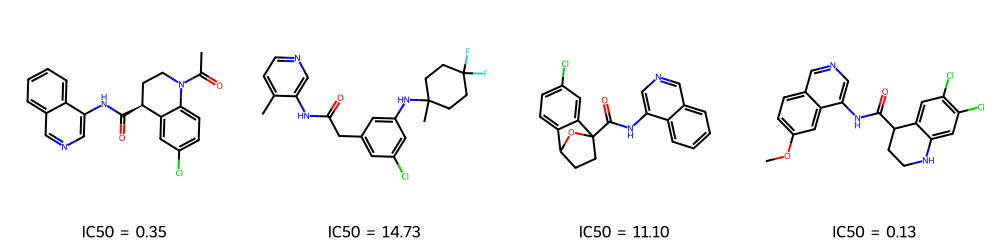

In [4]:
from rdkit.Chem import Draw
import math

# Take a random sample of 4 molecules
subset = df.sample(4)

# RDKit Mol objects
mols_to_draw = list(subset["mol"])

# Legends: use f_avg_IC50 for each sampled row
legends = []
for v in subset["f_avg_IC50"]:
    if isinstance(v, float) and not math.isnan(v):
        legends.append(f"IC50 = {v:.2f}")
    else:
        legends.append("IC50 = n/a")

# Draw grid (4 per row)
img = Draw.MolsToGridImage(
    mols_to_draw,
    molsPerRow=4,
    subImgSize=(250, 250),
    legends=legends
)

img


## Section: Add calculated properties to the dataset

Task:  
Add new columns to `df` with calculated RDKit properties for each molecule.  
Suggested properties:
- Molecular weight  
- logP  
- Topological polar surface area (TPSA)  
- H-bond donors  
- H-bond acceptors  
- Rotatable bonds  
- Ring count  

The example below shows how to add molecular weight (`MW`).  
TODO: follow the same pattern to add the other properties.


In [5]:
from rdkit.Chem import rdMolDescriptors, Crippen, Lipinski

# Example: add molecular weight as a new column
df["MW"] = df["mol"].apply(rdMolDescriptors.CalcExactMolWt)

# TODO: add property columns
# df["logP"] = ...
# df["TPSA"] = ...
# df["HBD"] = ...
# df["HBA"] = ...
# df["RotatableBonds"] = ...
# df["Rings"] = ...

df.head()


,SMILES,CID,f_avg_IC50,series,mol,MW
0,CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl...,LUO-POS-e1dab717-11,0.275118,3-aminopyridine-like,<rdkit.Chem.rdchem.Mol object at 0x70531a162ea0>,498.112854
1,O=C(CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc...,LUO-POS-e1dab717-12,0.202767,3-aminopyridine-like,<rdkit.Chem.rdchem.Mol object at 0x70531a162f10>,524.128504
2,CNC(=O)C1(N2C[C@]3(CCN(c4cncc5ccccc45)C3=O)c3c...,MAT-POS-e48723dc-1,55.453947,Ugi,<rdkit.Chem.rdchem.Mol object at 0x70531a162f80>,474.145868
3,CNC(=O)C1(N2C[C@@]3(CCN(c4cncc5ccccc45)C3=O)c3...,MAT-POS-e48723dc-2,0.050000,Ugi,<rdkit.Chem.rdchem.Mol object at 0x70531a162ff0>,474.145868
4,CNC(=O)CN1C[C@@]2(CCN(c3cncc4ccccc34)C2=O)c2cc...,LUO-POS-9931618f-2,0.052757,Ugi,<rdkit.Chem.rdchem.Mol object at 0x70531a163060>,448.130218


## Section: Molecular weight distribution

Goal:  
Visualise the range of molecular weights in the dataset.

Instructions:  
1. `df["MW"]` should already contain the molecular weight for each molecule.  
2. The code cell below plots a histogram of these values using matplotlib.  
3. This shows how many molecules fall into each molecular weight range.

Task:  
Use this example as a template.  
After running it, plot similar histograms for the other calculated properties you added (for example: `logP`, `TPSA`, H-bond donors, etc.).


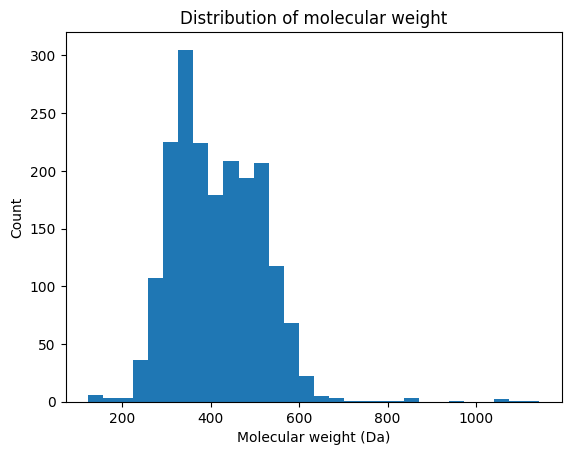

In [6]:
import matplotlib.pyplot as plt

# Example: histogram of molecular weight
plt.figure()
plt.hist(df["MW"], bins=30)
plt.xlabel("Molecular weight (Da)")
plt.ylabel("Count")
plt.title("Distribution of molecular weight")
plt.show()

# TODO:
# Make histograms for the other properties you added to df, e.g.:
# - logP
# - TPSA
# - HBD (H-bond donors)
# - HBA (H-bond acceptors)
# - RotatableBonds
# - Rings
#
# For each property:
#   1. Call plt.figure()
#   2. Call plt.hist(...) with the column
#   3. Label the axes and add a title
#   4. Call plt.show()


## Section: IC50 distribution

Task:  
1. Plot a histogram of the `f_avg_IC50` values in `df`.  
2. Comment on the shape of the distribution you see.

Guidance:  
- `f_avg_IC50` is the activity measurement for each compound (lower = more potent).  
- Your histogram should show how these activity values are distributed across the dataset.  
- Label the x-axis `f_avg_IC50`, the y-axis `Count`, and give the plot a title.  
- After plotting, describe what you observe:
  - Is the distribution skewed?
  - Are there clusters or multiple peaks?
  - Do you see mostly weak compounds and only a few strong ones?
  - Why might this pattern happen in a real screening / optimisation project?

Write the code and your interpretation in the cell below.


In [7]:
# TODO:
# 1. Create a histogram of df["f_avg_IC50"] (e.g. plt.hist(..., bins=30))
# 2. Label axes and add a title
# 3. Show the plot
# 4. Below the plot, write a short comment (print a multiline string) interpreting the distribution:
#    - Is anything surprising?
#    - How would you describe the spread of IC50 values?

# Your code here


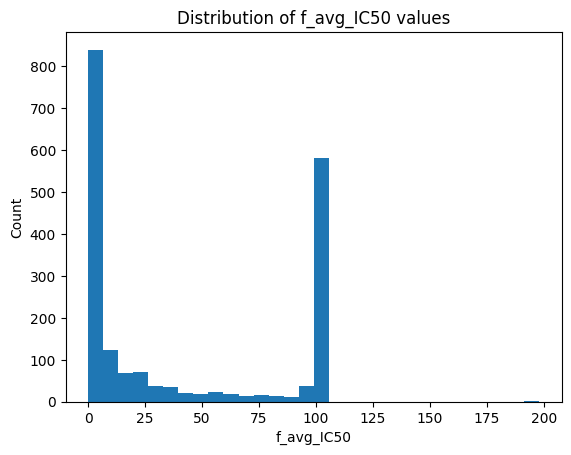

In [8]:

# Plot histogram of activity values
plt.figure()
plt.hist(df["f_avg_IC50"], bins=30)
plt.xlabel("f_avg_IC50")
plt.ylabel("Count")
plt.title("Distribution of f_avg_IC50 values")
plt.show()

## Section: Potency vs molecular weight (pIC50 vs MW) with trend line

Aim:  
Check if potency depends on molecular weight.

Procedure:
1. Keep only compounds with `f_avg_IC50` ≤ 98 µM.  
2. Compute `pIC50 = −log10(IC50 in µM) + 6`.  
   - Higher pIC50 = more potent.  
3. Plot a scatter of:
   - x-axis: `MW` (molecular weight, Da)  
   - y-axis: `pIC50`  
4. Fit a simple linear model (`pIC50` ~ `MW`) and plot the fitted line in red to show the overall trend.  
5. Report the Pearson correlation.

This lets us see both the raw points and the approximate linear relationship.


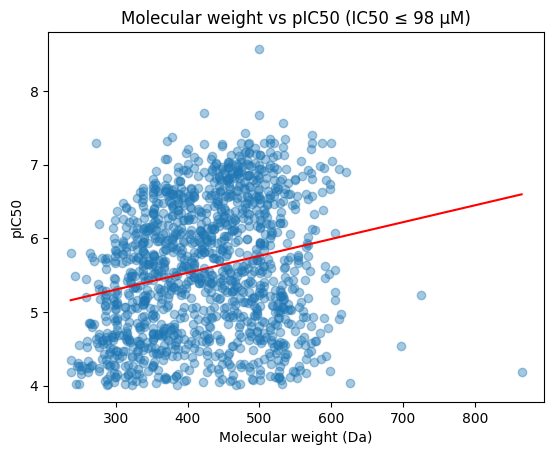

Pearson correlation (MW vs pIC50): 0.22061699002043747


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Filter to reasonably active compounds
df_sub = df[df["f_avg_IC50"] <= 98].copy()

# 2. Calculate pIC50 (unit-aware: IC50 given in µM)
df_sub["pIC50"] = -np.log10(df_sub["f_avg_IC50"]) + 6

# 3. Get x (MW) and y (pIC50) as arrays
x = df_sub["MW"].to_numpy()
y = df_sub["pIC50"].to_numpy()

# 4. Fit a straight line y = a*x + b
a, b = np.polyfit(x, y, 1)

# 5. Scatter plot of data
plt.figure()
plt.scatter(x, y, alpha=0.4)

# 6. Plot fitted line in red
x_line = np.linspace(x.min(), x.max(), 100)
y_line = a * x_line + b
plt.plot(x_line, y_line, color="red")

plt.xlabel("Molecular weight (Da)")
plt.ylabel("pIC50")
plt.title("Molecular weight vs pIC50 (IC50 ≤ 98 µM)")
plt.show()

# 7. Pearson correlation
corr = np.corrcoef(x, y)[0, 1]
print("Pearson correlation (MW vs pIC50):", corr)


## Task: Identify the most potent compounds and visualise them

Goal:  
Find the 5 most potent compounds in the dataset and visualise them.

Instructions:  
1. Potency is defined here as lowest `f_avg_IC50` (in µM).  
2. Identify the top 5 most potent compounds.  
3. Visualise those molecules in an RDKit grid.  
4. Include each compound’s IC50 value in the legend under the structure (e.g. `IC50 = 0.12 µM`).


In [10]:
# Your code here


## Task: Most potent compounds by series

Goal:  
For each chemical series (column `series`), identify the 5 most potent compounds and visualise them.

Instructions:  
1. For each unique `series`, rank the molecules by `f_avg_IC50` (ascending).  
2. Take the top 5 per series.  
3. Visualise these molecules in an RDKit grid.  
4. Include both the series name and IC50 value in the legend for each molecule.


In [11]:
# Your code here


## Task: Lipinski filtering

Goal:  
Identify which molecules in the dataset fail Lipinski's "Rule of Five", and quantify how they fail.

Lipinski rules (a molecule is generally considered acceptable if all are true):  
- Molecular weight (MW) ≤ 500  
- logP ≤ 5  
- H-bond donors (HBD) ≤ 5  
- H-bond acceptors (HBA) ≤ 10  

Instructions:  
1. For each molecule, calculate MW, logP, HBD, and HBA.  
2. Work out which molecules violate each individual rule.  
3. Count how many molecules violate:  
   - only the MW cutoff,  
   - only the logP cutoff,  
   - only the HBD cutoff,  
   - only the HBA cutoff.  
4. Plot a bar chart showing how often each rule is violated.  
5. Also create a dataframe of all molecules that fail at least one rule.


In [12]:
# Your code here


## Task: PAINS / structural alert hits

Goal:  
1. Identify molecules in the dataset that trigger PAINS alerts or structural alerts (Brenk).  
2. Visualise example flagged molecules and label them with the alert.

Background:  
- **PAINS (Pan-Assay INterference compoundS)** are substructures that often cause false or misleading activity in biochemical assays (they look active, but for the wrong reason).  
- **Structural alerts** (e.g. Brenk alerts) are substructures associated with chemical liabilities such as high reactivity, toxicity risk, or instability.  
In early drug discovery, especially hit triage, these compounds are often flagged and deprioritised.

What this cell does:  
1. Uses RDKit’s `FilterCatalog` to apply PAINS and Brenk filters.  
2. Marks each molecule in `df` as a PAINS hit and/or structural alert hit.  
3. Shows summary counts.  
4. Displays up to 5 PAINS hits and 5 structural alert hits in a grid, with captions indicating which alert was triggered.


Total molecules: 1926
PAINS hits: 32
Structural alert hits: 318
PAINS examples:


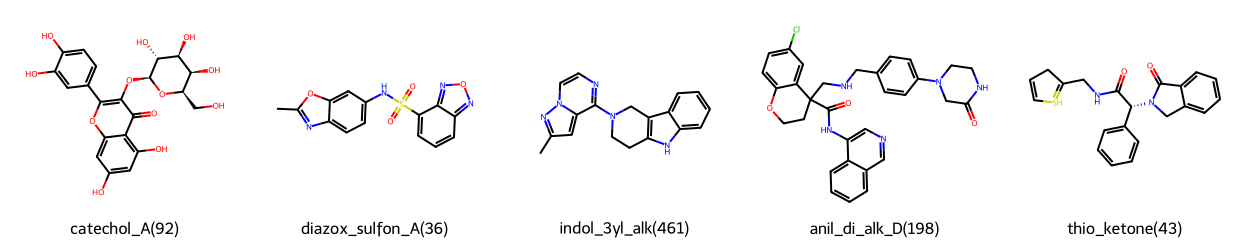

Structural alert examples:


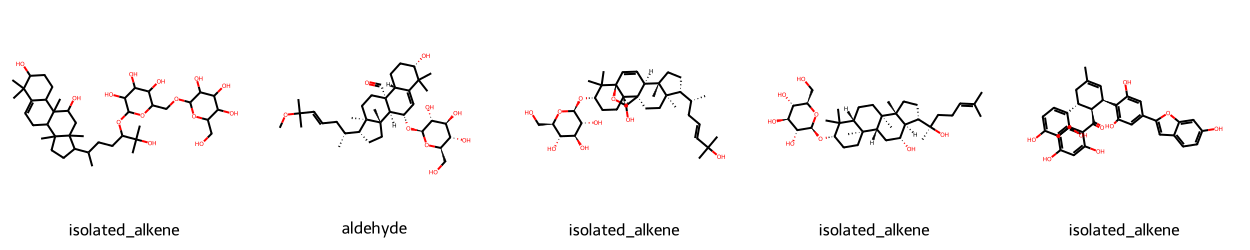

In [13]:
from rdkit import Chem
from rdkit.Chem import FilterCatalog, Draw
from IPython.display import display

# 1. Build PAINS and Brenk catalogs
params_pains = FilterCatalog.FilterCatalogParams()
params_pains.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.PAINS)
pains_catalog = FilterCatalog.FilterCatalog(params_pains)

params_struct = FilterCatalog.FilterCatalogParams()
params_struct.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.BRENK)
struct_catalog = FilterCatalog.FilterCatalog(params_struct)

def get_alert_info(match_list):
    """
    Given catalog.GetMatches(mol), return:
      - alert_desc: short human-readable description of the first alert
    Tries to work with different RDKit versions.
    """
    if not match_list:
        return None

    first = match_list[0]

    # RDKit may give FilterMatch objects that have GetEntry() and GetDescription()
    if hasattr(first, "GetEntry"):
        try:
            desc = first.GetDescription()
        except AttributeError:
            entry = first.GetEntry()
            desc = entry.GetDescription() if hasattr(entry, "GetDescription") else "alert"
        return desc

    # Or RDKit may give FilterCatalogEntry objects directly
    if hasattr(first, "GetDescription"):
        return first.GetDescription()

    return "alert"

# 2. Apply filters to each molecule in df
pains_hit_list = []
struct_hit_list = []
pains_desc_list = []
struct_desc_list = []

for mol in df["mol"]:
    pains_matches = pains_catalog.GetMatches(mol)
    struct_matches = struct_catalog.GetMatches(mol)

    pains_desc = get_alert_info(pains_matches)
    struct_desc = get_alert_info(struct_matches)

    pains_hit_list.append(len(pains_matches) > 0)
    struct_hit_list.append(len(struct_matches) > 0)

    pains_desc_list.append(pains_desc)
    struct_desc_list.append(struct_desc)

df["PAINS_hit"] = pains_hit_list
df["struct_alert_hit"] = struct_hit_list
df["PAINS_desc"] = pains_desc_list
df["struct_alert_desc"] = struct_desc_list

# 3. Summary
print("Total molecules:", len(df))
print("PAINS hits:", df["PAINS_hit"].sum())
print("Structural alert hits:", df["struct_alert_hit"].sum())

# 4. Take up to 5 PAINS hits and 5 structural alert hits
pains_df = df[df["PAINS_hit"]].head(5).copy()
struct_df = df[df["struct_alert_hit"]].head(5).copy()

# Legends will just be the alert description
pains_legends = [
    desc if desc is not None else "PAINS alert"
    for desc in pains_df["PAINS_desc"]
]

struct_legends = [
    desc if desc is not None else "structural alert"
    for desc in struct_df["struct_alert_desc"]
]

# 5. Visualise PAINS examples
if len(pains_df) > 0:
    print("PAINS examples:")
    img_pains = Draw.MolsToGridImage(
        list(pains_df["mol"]),
        molsPerRow=5,
        subImgSize=(250, 250),
        legends=pains_legends,
    )
    display(img_pains)
else:
    print("No PAINS hits found.")

# 6. Visualise structural alert examples
if len(struct_df) > 0:
    print("Structural alert examples:")
    img_struct = Draw.MolsToGridImage(
        list(struct_df["mol"]),
        molsPerRow=5,
        subImgSize=(250, 250),
        legends=struct_legends,
    )
    display(img_struct)
else:
    print("No structural alert hits found.")


## Task: Similarity to the lead compound

This SMILES represents the reported lead compound from the COVID Moonshot paper:

`N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4ccccc34)C2)CC1`

Task:  
1. Compute similarity between this lead compound and every molecule in the dataset using Morgan fingerprints (radius 2) and Tanimoto similarity.  
2. Take the 20 most similar molecules.  
3. Sort those 20 molecules by potency (most potent first = lowest `f_avg_IC50`).  
4. Visualise them in a grid.  
5. Use the IC50 (`f_avg_IC50`) of each molecule as the caption.


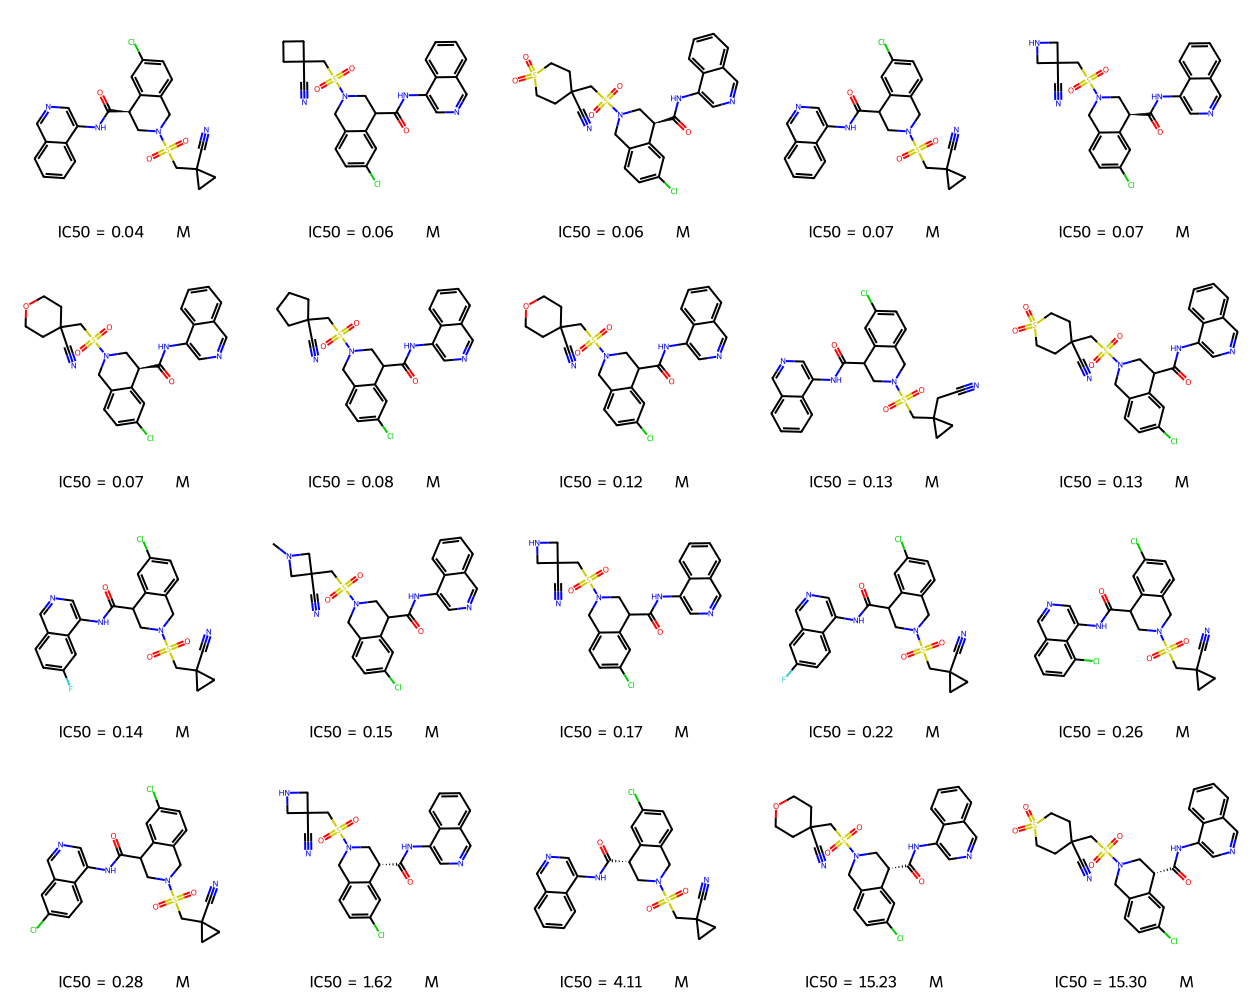

In [14]:
from rdkit import Chem, DataStructs
from rdkit.Chem import rdMolDescriptors, Draw
from IPython.display import display

# Define the lead compound from the paper
lead_smiles = 'N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C(C(=O)Nc3cncc4ccccc34)C2)CC1'
lead_mol = Chem.MolFromSmiles(lead_smiles)

# Morgan fingerprint for the lead
lead_fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
    lead_mol,
    radius=2,
    nBits=2048
)

# Similarity function
def tanimoto_to_lead(mol):
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(
        mol,
        radius=2,
        nBits=2048
    )
    return DataStructs.TanimotoSimilarity(lead_fp, fp)

# 1. Calculate similarity for each molecule in the dataset
df["similarity_to_lead"] = df["mol"].apply(tanimoto_to_lead)

# 2. Take the 20 most similar
top20 = df.sort_values("similarity_to_lead", ascending=False).head(20).copy()

# 3. Sort those 20 by potency (lowest IC50 = most potent)
top20 = top20.sort_values("f_avg_IC50", ascending=True)

# 4. Prepare molecules and legends
mols_to_draw = list(top20["mol"])
legends = [
    f"IC50 = {ic50:.2f} µM" if ic50 is not None else "IC50 = n/a"
    for ic50 in top20["f_avg_IC50"]
]

# 5. Draw grid (5 per row)
img = Draw.MolsToGridImage(
    mols_to_draw,
    molsPerRow=5,
    subImgSize=(250, 250),
    legends=legends
)

display(img)
